In [1]:
import numpy as np
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cmocean
from pyproj import Proj

In [2]:
plt.style.use('dark_background')

font = {'size' : 16}

matplotlib.rc('font', **font)

In [3]:
## YYYY-MM-DD
start_date = np.datetime64('2018-01-01')
end_date   = np.datetime64('2018-01-15')
num_days = (end_date - start_date).tolist().days

# variable to load
VAR = 'CHL'

# algorithm
ALG = 'chl_ocx'

# Binning period
BIN = 'DAY'  # DAY, 8D, MO

# Spatial resolution
SRES = '4km'   # 4km, 9km

In [4]:
# Build a list of URLs and datetime objects
dap_urls = []
the_days = []

url_base = "https://oceandata.sci.gsfc.nasa.gov:443/opendap/MODISA/L3SMI/"

for ii in range(num_days):
    
    curr_date = start_date + ii
    
    curr_year = curr_date.tolist().year
    ref_date = np.datetime64('{0:d}-01-01'.format(curr_year))
    
    day_num = 1 + (curr_date - ref_date).tolist().days
    
    # We need to change the formatting a bit depending on the binning
    do = True
    if BIN == 'DAY':
        time_str = 'A{0:d}{1:03d}'.format(curr_year, day_num)
    elif BIN == '8D':
        if (day_num - 1) % 8 == 0:
            targ_day = day_num + 7
            if targ_day > 365:
                targ_day = 365
            
            time_str = 'A{0:d}{1:03d}{2:d}{3:03d}'.format(curr_year, day_num, curr_year, targ_day)
        else:
            # There isn't an 8D set starting here
            do = False
    
    if do:
        file_url = url_base + \
                '{0:d}/{1:03d}/{2}'.format(curr_year, day_num, time_str) + \
                '.L3m_{0}_{1}_{2}_{3}'.format(BIN, VAR, ALG, SRES) + \
                '.nc'
    
        dap_urls += [file_url]
        the_days += [curr_date]
    
print('dap_urls containts {0:d} urls for {1} data.'.format(len(dap_urls), VAR))

dap_urls containts 14 urls for CHL data.


In [5]:
lon_lb = -100
lon_ub = -75

lat_lb = 15
lat_ub = 30

In [6]:
def preprocess_set(dset, time):
    return dset.sel(lon=slice(lon_lb,lon_ub),lat=slice(lat_ub,lat_lb))

In [7]:
data_sets = [preprocess_set(xr.open_dataset(url), ind) \
             for (url,ind) \
             in zip(dap_urls, np.arange(num_days))]

In [8]:
time_array = xr.DataArray(the_days, None, 'time', 'time')

In [9]:
merged = xr.concat(data_sets, time_array)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


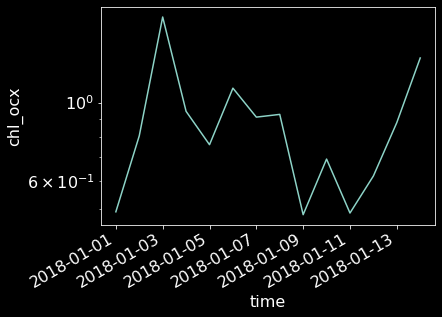

In [10]:
merged.chl_ocx.mean(dim=['lat', 'lon']).plot()
plt.gca().set_yscale('log')

In [11]:
mean_chl = merged.chl_ocx.mean(dim='time').data
std_chl  = merged.chl_ocx.std( dim='time').data

lon = merged.lon.data
lat = merged.lat.data

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [12]:
meridians = np.round(np.linspace(lon.min(), lon.max(), 5))
parallels = np.round(np.linspace(lat.min(), lat.max(), 5))

In [13]:
proj = Proj(proj='wag7', lon_0 = lon.mean(), lat_0 = lat.mean())

In [14]:
LON, LAT = np.meshgrid(lon, lat)

Xp, Yp = proj(LON, LAT, inverse=False)

In [15]:
def AddParallels_and_Meridians(
        ax, proj,
        parallels, meridians,
        latitude, longitude,
        label_parallels = True,
        label_meridians = True):

    for mer in meridians:
        xs, ys = proj(mer*np.ones(latitude.shape), latitude, inverse=False)
        ax.plot(xs, ys, '--g', linewidth=1)
    for par in parallels:
        xs, ys = proj(longitude, par*np.ones(longitude.shape), inverse=False)
        ax.plot(xs, ys, '--g', linewidth=1)

    xs, ys = proj(meridians, latitude.min()*np.ones(meridians.shape), inverse=False)
    ax.set_xticks(xs)
    if label_meridians:
        ax.set_xticklabels(['{0:d}'.format(int(mer)) for mer in meridians])
    else:
        ax.set_xticklabels([])

    xs, ys = proj(longitude.min()*np.ones(parallels.shape), parallels, inverse=False)
    ax.set_yticks(ys)
    if label_parallels:
        ax.set_yticklabels(['{0:d}'.format(int(par)) for par in parallels])
    else:
        ax.set_yticklabels([])

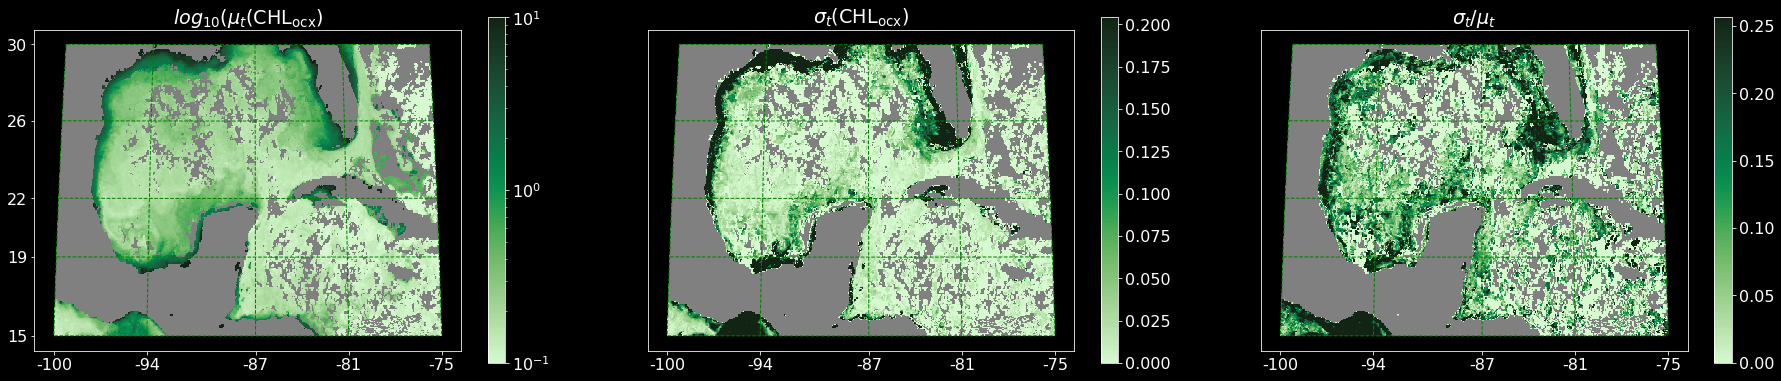

In [17]:
gridspec_props = dict(wspace = 0.15, hspace = 0.15, left = 0.1, right = 0.95, bottom = 0.1, top = 0.9)

rat   = (Xp.max() - Xp.min()) / (Yp.max() - Yp.min())
rat  *= (3./1) * (1.2)
fig_h = 6.

cmap = plt.get_cmap('cmo.algae')
cmap.set_bad('gray', 1.)

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(fig_h*rat, fig_h), gridspec_kw = gridspec_props)

q0 = axes[0].pcolormesh(Xp, Yp, mean_chl, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), cmap=cmap)

to_plot = std_chl
cv = np.nanpercentile(to_plot, 90)
q1 = axes[1].pcolormesh(Xp, Yp, to_plot, vmin=0, vmax=cv, cmap=cmap)

to_plot = std_chl / (mean_chl + 1e-5)
cv = np.nanpercentile(to_plot, 90)
q2 = axes[2].pcolormesh(Xp, Yp, to_plot, vmin=0, vmax=cv, cmap=cmap)

plt.colorbar(q0, ax=axes[0])
plt.colorbar(q1, ax=axes[1])
plt.colorbar(q2, ax=axes[2])

axes[0].set_title('$log_{10}(\mu_t(\mathrm{CHL}_{\mathrm{ocx}})$')
axes[1].set_title('$\sigma_t(\mathrm{CHL}_{\mathrm{ocx}})$')
axes[2].set_title('$\sigma_t / \mu_t$')

for ax in axes:
    AddParallels_and_Meridians(ax, proj, parallels, meridians, lat, lon)
    ax.set_aspect('equal')
    
for ax in axes[1:]:
    ax.set_yticks([])